# Friends Classification Text (xgB) - 2

This is classification of dialogue in FRIENDS TV Series.

<!-- https://stackoverflow.com/questions/61000500/tensorflow-keras-bert-multiclass-text-classification-accuracy -->

In [3]:
import pandas as pd
import re
import numpy as np
import time

import os
import pprint
import tensorflow as tf

import sys
sys.path.insert(1, '../../src/all_functions/')

from text_tools import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import joblib
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [4]:
# help(drive.mount)

In [5]:
# PATH_DATA = 'gdrive/'
PATH_DATA = '../../data/'

## Importing Data

In [14]:
df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season2_2.csv')
df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season2_2.csv')

/Users/alamhanz/anaconda/envs/p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
data_train = df_dlg_seen[(df_dlg_seen.is_train == True)&(df_dlg_seen.label!=0)][['text1','text2','label']]
data_train['label'] = data_train['label']-1
data_train = data_train[~(data_train.text1.isnull())]

data_test = df_dlg_seen[(df_dlg_seen.is_train == False)&(df_dlg_seen.label!=0)][['text1','text2','label']]
data_test['label'] = data_test['label']-1
data_test = data_test[~(data_test.text1.isnull())]

data_unseen = df_dlg_unseen[(df_dlg_unseen.label!=0)][['text1','text2','label']]
data_unseen['label'] = data_unseen['label']-1
data_unseen = data_unseen[~(data_unseen.text1.isnull())]

In [16]:
data_train.shape

(25981, 3)

In [17]:
data_test.shape

(8593, 3)

In [18]:
data_unseen.shape

(8305, 3)

In [19]:
XX = data_test.label.value_counts()
XX/XX.sum()

1    0.178867
0    0.177470
3    0.167811
2    0.167229
4    0.160014
5    0.148609
Name: label, dtype: float64

## Tokenizer - TFIDF

In [20]:
MAX_LEN = 50
EMBED_SIZE = 128

In [21]:
OH = OneHotEncoder()

In [22]:
data_train.head()

,text1,text2,label
1,c'mon you're going out with the guy there's go...,all right joey be nice so does he have a hump ...,3
3,just because i don't want her to go through wh...,okay everybody relax this is not even a date i...,2
4,okay everybody relax this is not even a date i...,sounds like a date to me,3
7,then i look down and i realize there's a phone...,instead of,4
9,that's,never had that dream,4


In [23]:
data_test.head()

,text1,text2,label
0,there's nothing to tell he's just some guy i w...,c'mon you're going out with the guy there's go...,4
2,all right joey be nice so does he have a hump ...,wait does he eat chalk,5
6,oh yeah had that dream,then i look down and i realize there's a phone...,3
8,instead of,that's,3
11,no,all of a sudden the phone starts to ring now i...,3


In [24]:
df_dlg_unseen.head()

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,text2,len_dialogue5,is_null2,ids,text1,label_prev,label_str_prev,is_null2_prev
0,0901,3,[rachel's room],2,joey,5,9,uh... look rach...(ross enters.) hey ross is...,uh look rach hey ross is here hey look it's my...,16,False,49646,so uh i guess we should make it official huh,1.0,rachel,False
1,0901,4,[rachel's room],2,ross,2,9,hey joey. (to rachel) hey you.,joey you,2,False,49647,uh look rach hey ross is here hey look it's my...,5.0,joey,False
2,0901,5,[rachel's room],2,rachel,1,9,hey you.,you,1,False,49648,joey you,2.0,ross,False
3,0901,6,[rachel's room],2,joey,5,9,hey and look he brought flowers. thanks ross...,hey and look he brought flowers thanks ross bu...,16,False,49649,you,1.0,rachel,False
4,0901,7,[rachel's room],2,ross,2,9,you're weird today. (he turns to rachel and ...,you're weird today listen i uh wanted to talk ...,13,False,49650,hey and look he brought flowers thanks ross bu...,5.0,joey,False


In [25]:
corpus = data_train['text1'].tolist()+data_test['text1'].tolist()+data_train['text2'].tolist()+data_test['text2'].tolist()
vectorizer = TfidfVectorizer(min_df = 0.05, max_features = MAX_LEN)
vectorizer.fit(corpus)

TfidfVectorizer(max_features=50, min_df=0.05)

In [26]:
def get_input(df):
    txt = df['text1']
    X1 = vectorizer.transform(txt).toarray()
    txt = df['text2']
    X2 = vectorizer.transform(txt).toarray()
    label = df['label']
    
    X = np.concatenate([X1,X2],axis = 1)
    return X,label.values

In [27]:
X_train,label_train = get_input(pd.concat([data_train,data_test]))
X_unseen,label_unseen = get_input(data_unseen)

In [28]:
OH.fit(label_train.reshape(len(label_train),-1))

OneHotEncoder()

In [29]:
y_train = OH.transform(label_train.reshape(len(label_train),-1)).toarray()
# y_test = OH.transform(label_test.reshape(len(label_test),-1)).toarray()
y_unseen = OH.transform(label_unseen.reshape(len(label_unseen),-1)).toarray()

In [30]:
label_train

array([3, 2, 3, ..., 4, 0, 0])

In [31]:
X_train.shape

(34574, 76)

## Training Model

In [32]:
def xgb_evaluate(max_depth,learning_rate,n_estimators,
                 gamma, reg_alpha,reg_lambda,X=X_train,y=label_train):

    md= int(max_depth)
    lr= max(learning_rate,0)
    ne= int(n_estimators)
    gamma= max(gamma, 0) # 0
    ra= max(reg_alpha, 0) # 0
    rl= max(reg_lambda, 0) # 1
    see= 123
    
    xgB=XGBClassifier(max_depth=md,learning_rate=lr,
                 n_estimators=ne,gamma=gamma,reg_alpha=ra,
                 reg_lambda=rl,seed=see, 
                 nthread=2,num_classes=6)
    cv_results = cross_validate(xgB, X, y, cv=5, scoring='f1_macro', n_jobs= 2)
    return cv_results['test_score'].mean()

In [33]:
xgbBO = BayesianOptimization(xgb_evaluate, 
                {'max_depth': (10,20),'learning_rate': (0.2, 0.5),
                    'n_estimators': (8,16),'gamma': (0.1, 2),'reg_alpha': (1, 5),
                    'reg_lambda': (1.5, 44.5)})

In [34]:
xgbBO.maximize(init_points=15, n_iter=5)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
|  1        |  0.2024   |  1.39     |  0.3547   |  19.94    |  12.98    |  4.307    |  19.68    |
|  2        |  0.2038   |  0.5288   |  0.2224   |  19.77    |  12.56    |  2.471    |  8.847    |
|  3        |  0.2014   |  1.736    |  0.4719   |  14.33    |  11.77    |  4.424    |  25.69    |
|  4        |  0.2029   |  0.3662   |  0.2123   |  12.36    |  12.64    |  3.452    |  26.16    |
|  5        |  0.2005   |  0.207    |  0.4195   |  12.55    |  9.091    |  4.467    |  2.67     |
|  6        |  0.2005   |  1.542    |  0.3044   |  18.71    |  8.339    |  4.859    |  24.06    |
|  7        |  0.1993   |  0.5369   |  0.4603   |  14.19    |  13.12    |  1.534    |  2.809    |
|  8        |  0.202    |  0.4802   |  0.3357   |  19.63    |  14.36    |  3.171    |  14.72    |
|  9        |  0.202

In [35]:
# |  17       |  0.2066   |  1.0      |  0.2      |  13.0     |  11.51    |  4.0      |  2.0      |

In [37]:
par = xgbBO.max['params']
par

{'gamma': 1.1634414163723379,
 'learning_rate': 0.351682006791587,
 'max_depth': 18.499530350387243,
 'n_estimators': 15.257212440238941,
 'reg_alpha': 3.3628038431887086,
 'reg_lambda': 38.9696429556927}

In [38]:
# par = {'gamma': 1.0,
#  'learning_rate': 0.2,
#  'max_depth': 13.00295161270265,
#  'n_estimators': 11.511195874852616,
#  'reg_alpha': 4.0,
#  'reg_lambda': 2.0}
par['max_depth'] = int(par['max_depth'])
par['n_estimators'] = int(par['n_estimators'])

In [39]:
xgB0=XGBClassifier(**par)
xgB0.fit(X_train,label_train)

/Users/alamhanz/anaconda/envs/p37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:41:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.1634414163723379,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.351682006791587, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=15, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0,
              reg_alpha=3.3628038431887086, reg_lambda=38.9696429556927,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

## Testing

In [40]:
data_unseen

,text1,text2,label
0,so uh i guess we should make it official huh,uh look rach hey ross is here hey look it's my...,4
1,uh look rach hey ross is here hey look it's my...,joey you,1
2,joey you,you,0
3,you,hey and look he brought flowers thanks ross bu...,4
4,hey and look he brought flowers thanks ross bu...,you're weird today listen i uh wanted to talk ...,1
...,...,...,...
9827,this is harder than i thought it would be,oh it's gonna be okay,3
9828,oh it's gonna be okay,do you guys have to go to the new house right ...,0
9829,do you guys have to go to the new house right ...,we got some time,2
9830,we got some time,okay should we get some coffee,0


In [41]:
y_pred_label = xgB0.predict(X_unseen)
# y_pred_label = np.argmax(y_pred,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.22      0.28      0.24      1410
           1       0.19      0.23      0.21      1497
           2       0.21      0.25      0.22      1369
           3       0.23      0.23      0.23      1401
           4       0.23      0.17      0.20      1360
           5       0.22      0.12      0.15      1268

    accuracy                           0.21      8305
   macro avg       0.22      0.21      0.21      8305
weighted avg       0.22      0.21      0.21      8305



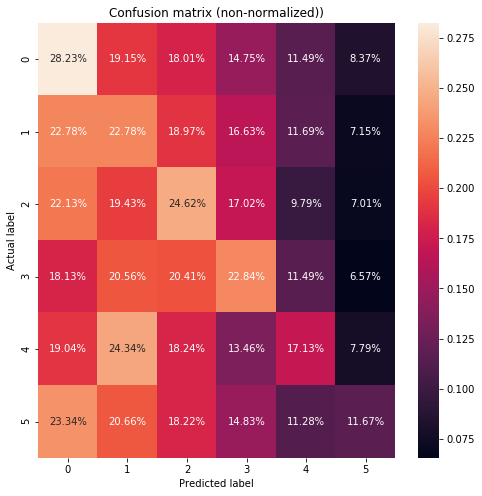

In [42]:
report = classification_report(y_true_label, y_pred_label)
print(report)


def plot_cm(labels, predictions, p=0.5):
#     cm = confusion_matrix(labels, predictions)
#     plt.figure(figsize=(5, 5))
#     sns.heatmap(cm, annot=True, fmt="d")
    cm = confusion_matrix(labels, predictions)
    cm = (cm.transpose()/cm.sum(axis = 1)).transpose()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2%")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_true_label, y_pred_label)